# Real Estate Price Prediction


**План**
* [Подготовка](#kaggle_path)
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)


### Гипотезы

[Гипотеза_01_id](#hypo01)

[Гипотеза_02_DistrictId](#hypo02)

[Гипотеза_03_Square.corr](#hypo03)

[Гипотеза_04_Square=LifeSquare + KitchenSquare](#hypo04)

[Гипотеза_05_Floor](#hypo05)

[Гипотеза_06_HouseFloor](#hypo06)

[Гипотеза_07_Floor_in_House](#hypo07)

[Гипотеза_08_Social_corr](#hypo08)

[Гипотеза_09_Good_floor](#hypo09)

[Гипотеза_10_Healthcare_1_alive](#hypo10)

[Гипотеза_11_Healthcare_1_Ecology_1_cor](#hypo11)

### Подготовка [<a class='anchor' id='kaggle_path'>](http://)

**Подключение библиотек и скриптов**

In [3]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
import xgboost as xgb

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
matplotlib.rcParams.update({'font.size': 14})

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
SAMPLE_PATH = '/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv'

### Загрузка данных [<a class='anchor' id='load'>](http://)

**Описание набора данных**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
print('Строк в тренировочном наборе :\t', train_df.shape[0])
print('Строк в тестовом наборе :\t', test_df.shape[0])

Строк в тренировочном наборе :	 10000
Строк в тестовом наборе :	 5000


In [13]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [14]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Гипотеза_01_id**:[<a class='anchor' id='hypo01'>]() Поле id идентификатор квартиры (уникальный) информации для модели не несет. **Решение**: перевести в строковый. Далее исключить

**Гипотеза_02_DistrictId**:[<a class='anchor' id='hypo02'>]() Поле DistrictId не является вещественным признаком. **Решение**: перевести в строковый. Далее сгенерировать новые признаки на его основе.

In [15]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
- Анализ данных
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

In [16]:
# первый взгляд на параметр 
def first_look(Series1, max_count=0, bins=10, quan=0.999):
    Series = Series1.copy()
    # простая корректировка по выбросам
    Series.drop(Series[Series > Series.quantile(quan)].index, inplace=True)
    # расчет осовных значений
    Series_mean = round(Series.mean(), 2)
    Series_median = Series.median()
    Series_name = Series.name
    # рачет максимального выброса
    max_count=np.histogram(Series, bins=bins)[0].max()
    
    plt.figure(figsize = (16, 8))
    Series.hist(bins=bins)
    plt.ylabel('Count')
    plt.xlabel(Series_name)
    # отображение среднего и медианы
    y = np.linspace(0, max_count, bins)
    plt.plot([Series_mean] * bins, y, label='mean  : {:,.2f}'.format(Series_mean),  linewidth=4)
    plt.plot([Series_median] * bins, y, label='median: {:,.2f}'.format(Series_median),  linewidth=4)
    plt.legend()
    plt.title( Series_name + ' distribution')
    plt.show()


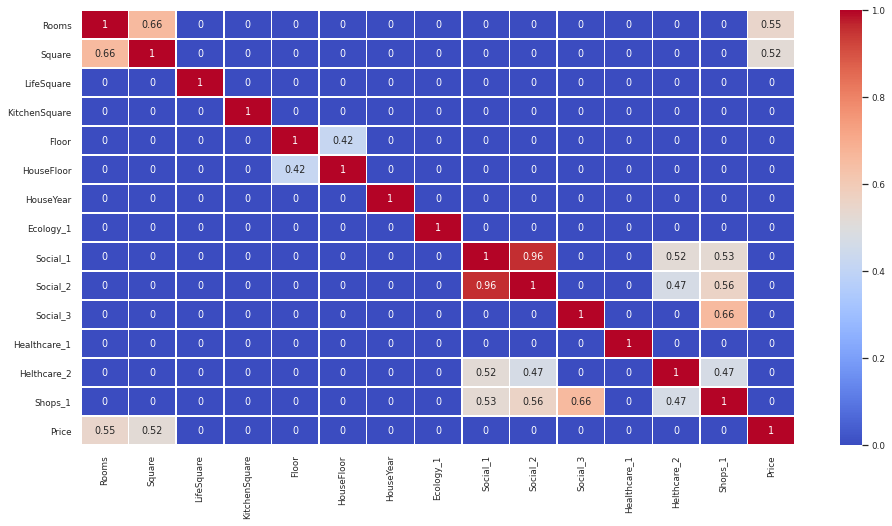

In [17]:
train_df_corr = train_df.corr()
import seaborn as sns
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
train_df_corr_round = np.round(train_df_corr, 2)
train_df_corr_round[np.abs(train_df_corr) < 0.3] = 0
sns.heatmap(train_df_corr_round, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

> > **Гипотеза_08_Social_corr**[<a class='anchor' id='hypo08'>]()
 Признаки Scial_1 и Social_2 на первый взгляд сильно коррелированы проверить пристальней

### Целевая переменная Price

In [18]:
train_df.Price.describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

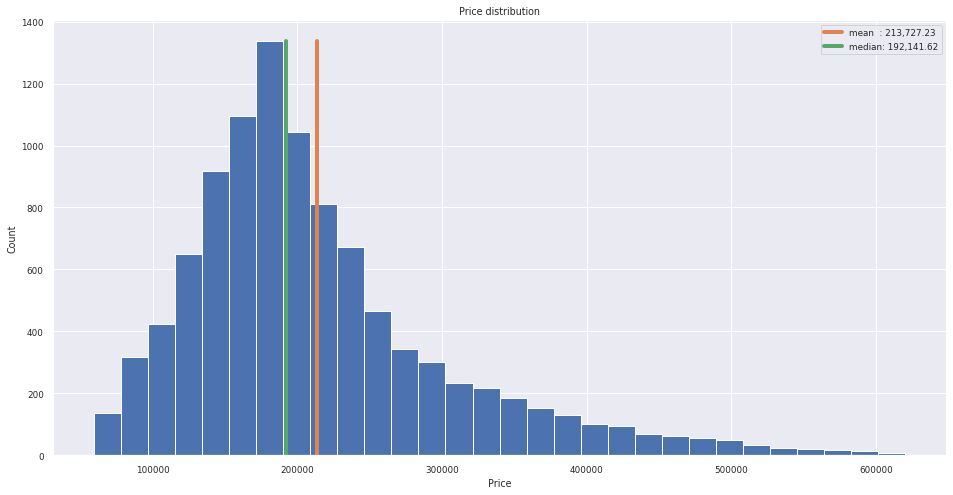

In [19]:
first_look(train_df.Price, bins=30)

> Медиана и среднее значение довольно близки друг к другу. Это свидетельствует о равномерности распределения значеия Price 

### Количественные переменные. Square LifeSquare KitchenSquare

In [20]:
train_df.select_dtypes(exclude='object').describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Гипотеза_03_Square.corr**[<a class='anchor' id='hypo03'>]()

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Данные признаки чрезвычайно коррелированны. **Решение:** Проверить корреляцию

**Гипотеза_04_Square=LifeSquare + KitchenSquare**[<a class='anchor' id='hypo04'>]()

> Square вычислима исходя из LifeSquare KitchenSquare. **Решение:** проверить


>Поводим грубую очистку от выбросов

In [21]:
rooms_slr = train_df[['Square', 'LifeSquare', 'KitchenSquare']]
rooms_slr.dropna(inplace=True)
rooms_slr.drop(rooms_slr.loc[rooms_slr.LifeSquare > rooms_slr.LifeSquare.quantile(.9999)].index, inplace=True)
rooms_slr.drop(rooms_slr.loc[rooms_slr.KitchenSquare > rooms_slr.KitchenSquare.quantile(.9998)].index, inplace=True)
rooms_slr.drop(rooms_slr.loc[rooms_slr.Square > rooms_slr.Square.quantile(.9997)].index, inplace=True)

rooms_slr['Square_component'] = train_df.LifeSquare + train_df.KitchenSquare + 5
rooms_slr

,Square,LifeSquare,KitchenSquare,Square_component
1,39.832524,23.169223,8.0,36.169223
2,78.342215,47.671972,10.0,62.671972
4,64.285067,38.562517,9.0,52.562517
5,62.528465,47.103833,6.0,58.103833
6,33.938750,21.772930,9.0,35.772930
...,...,...,...,...
9995,49.090728,33.272626,6.0,44.272626
9996,64.307684,37.038420,9.0,51.038420
9997,29.648057,16.555363,5.0,26.555363
9998,32.330292,22.326870,5.0,32.326870


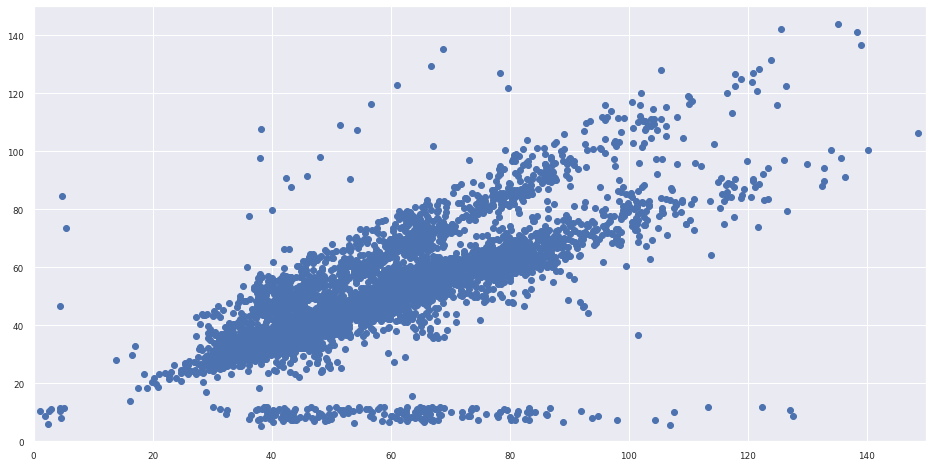

In [22]:
plt.figure(figsize = (16, 8))
plt.ylim(None, 150)
plt.xlim(None, 150)

plt.scatter(rooms_slr.Square, rooms_slr.Square_component )
plt.show()

**Вывод:** Реальная площадь и вычислимая находятся в линейной зависимости. Возможно оставить только признак Square. Или удалить его,  оставить  LifeSquare и KitchenSquare

### Переменные Floor, HouseFloor

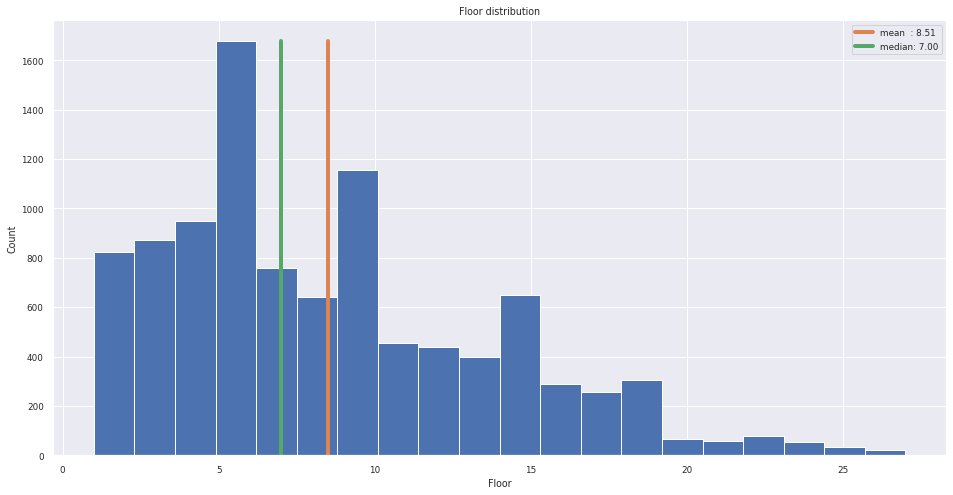

In [23]:
first_look(train_df.Floor, bins=20)

**Гипотеза_05_Floor**[<a class='anchor' id='hypo05'>]()

Признак довольно равномерно распределен, среднее значение 8 этаж. Значение этажа не может влиять на цену. Как вариант пометить категории 1-е этажи, последние этажи, средние этажи в совокупности с HouseFloor

[Почему чем выше этаж, тем дороже квартира](https://pr-flat.ru/blog/pochemu-chem-vyshe-etazh-tem-dorozhe-kvartira/#:~:text=%D0%9F%D0%BE%D1%87%D0%B5%D0%BC%D1%83%20%D1%87%D0%B5%D0%BC%20%D0%B2%D1%8B%D1%88%D0%B5%20%D1%8D%D1%82%D0%B0%D0%B6%2C%20%D1%82%D0%B5%D0%BC%20%D0%B4%D0%BE%D1%80%D0%BE%D0%B6%D0%B5%20%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80%D0%B0,-%D0%90%D0%B2%D1%82%D0%BE%D1%80%3A%20%D0%AE%D0%BB%D0%B8%D1%8F%20%D0%9A%D1%83%D0%B7%D0%BD%D0%B5%D1%86%D0%BE%D0%B2%D0%B0&text=%D0%9D%D0%B0%20%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C%20%D0%B6%D0%B8%D0%BB%D1%8C%D1%8F%20%D0%B2%D0%BB%D0%B8%D1%8F%D0%B5%D1%82%20%D1%81%D0%BE%D0%B2%D0%BE%D0%BA%D1%83%D0%BF%D0%BD%D0%BE%D1%81%D1%82%D1%8C,%D0%BA%D0%B0%D0%BA%20%D0%BD%D0%B8%D0%B6%D0%B5%2C%20%D1%82%D0%B0%D0%BA%20%D0%B8%20%D0%B2%D1%8B%D1%88%D0%B5.)

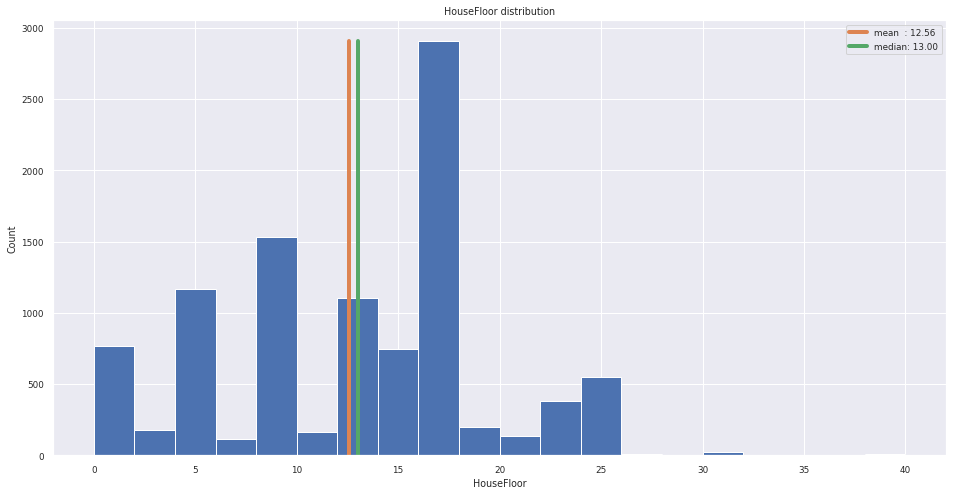

In [24]:
first_look(train_df.HouseFloor, bins=20)

>Видна явная гребенка на 5, 9, 12, 16 этажки

**Гипотеза_06_HouseFloor** [<a class='anchor' id='hypo06'>]()
Общая этажность не может влиять на  стоимость. В дальнейшем признак исключить.

**Гипотеза_07_Floor_in_House** [<a class='anchor' id='hypo07'>]()
Выделить в категорию 1,2 этажи средние, последний этаж 

### Переменная HouseYear[](http://)

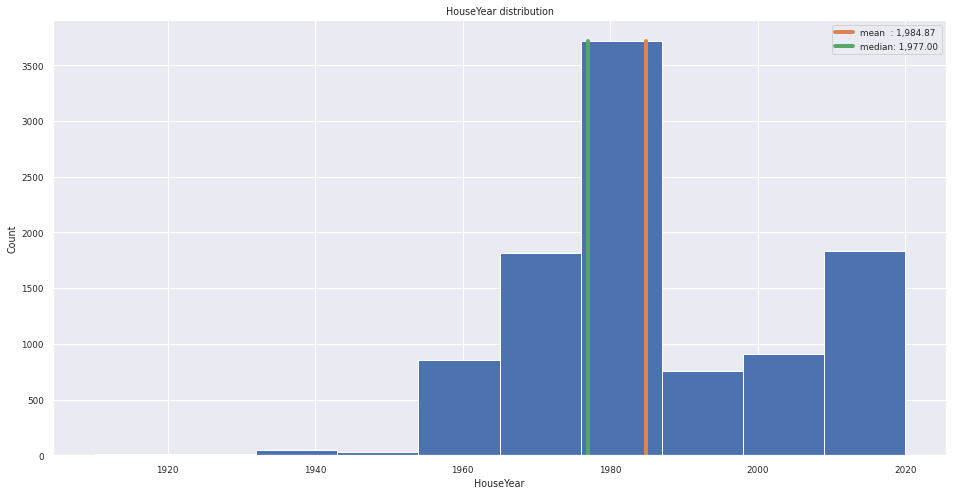

In [25]:

first_look(train_df.HouseYear)

### Переменные Social[](http://)

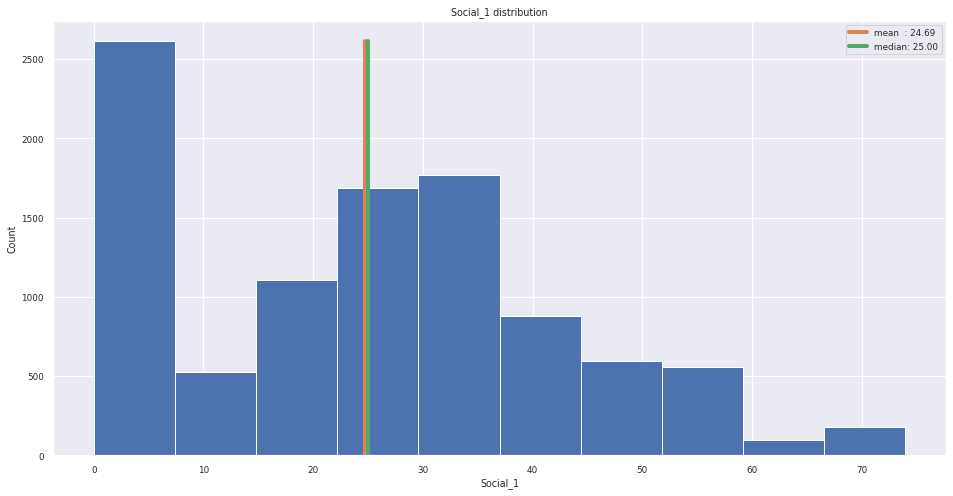

In [26]:
first_look(train_df.Social_1)

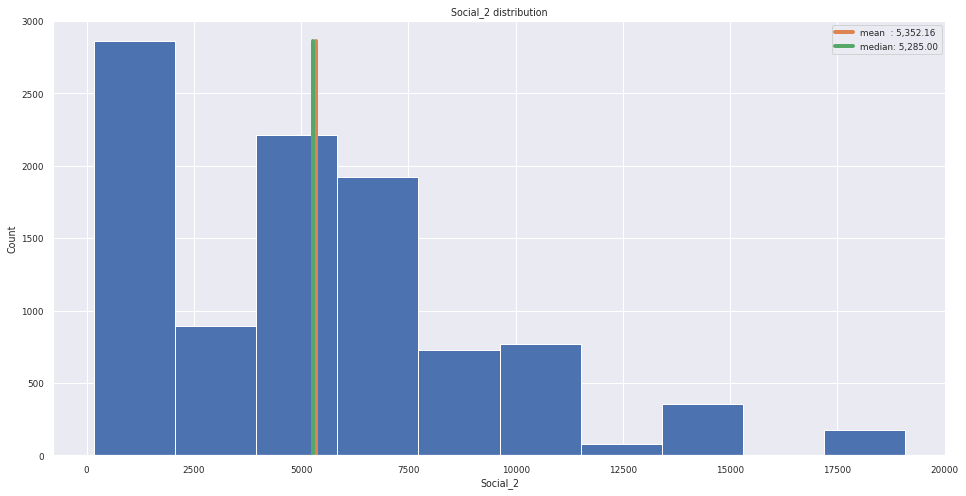

In [27]:
first_look(train_df.Social_2)

In [28]:
train_df[['Social_1', 'Social_2', 'Social_3']].describe()

,Social_1,Social_2,Social_3
count,10000.000000,10000.000000,10000.000000
mean,24.687000,5352.157400,8.039200
std,17.532614,4006.799803,23.831875
min,0.000000,168.000000,0.000000
25%,6.000000,1564.000000,0.000000
50%,25.000000,5285.000000,2.000000
75%,36.000000,7227.000000,5.000000
max,74.000000,19083.000000,141.000000


**Номинативные переменные**

In [29]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [30]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
209      1
117      1
207      1
205      1
Name: DistrictId, Length: 205, dtype: int64

In [31]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [32]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [33]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**Rooms**

In [34]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

>Rooms принимаем выбросы как > 6 и пропуски = 0  

In [35]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


In [36]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [37]:
train_df[train_df['Rooms'] > 6 ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1


> коррекция Rooms

In [38]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [39]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [40]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [41]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

>Проверка на консистентность

In [42]:
train_df[train_df.KitchenSquare > train_df.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2785,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,...,B,4,915,0,NaN,0,0,B,99079.960518,0
5273,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,...,B,21,5731,0,NaN,1,0,B,160488.033165,0
6505,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,105539.556275,0
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,B,2,629,1,NaN,0,0,A,108337.484207,0


> За выброс принимаем 
>1. неустановленные значения и все что выше q975
>2. <3

Коррекция KitchenSquare

In [43]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [44]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

>Повторная проверка на консистентность

In [45]:
train_df[train_df.KitchenSquare > train_df.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
161,6782,45,1.0,2.954309,5.257278,3.0,3,1.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,438005.182323,0
4496,15744,34,1.0,1.988943,2.642219,3.0,21,4.0,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,458378.777006,0
7470,14786,1,1.0,1.136859,4.525736,3.0,3,1.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,181434.825589,0
8572,10202,6,1.0,2.596351,4.604943,3.0,3,25.0,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,137597.601458,0
9869,3224,27,1.0,2.377248,0.873147,3.0,1,0.0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.941798,1


**HouseFloor, Floor**

In [46]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [47]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [48]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

> За аномалии принимаем 
> Floor>HouseFloor
> Floor=0

In [49]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [50]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [51]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

> генерация признака Floor в пределах [1, HouseFloor]

In [52]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [53]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [54]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [55]:
train_df[train_df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,25,4756,16,2857.0,5,8,B,243028.603096,0,0
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,30,6141,10,262.0,3,6,B,254084.534396,0,0


In [56]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [57]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

>пропуски в LifeSquare и Healthcare_1

In [58]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


**LifeSquare**

> Фиксация пробелов

In [59]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

> Коррекция LifeSquare=Square-KitchenSquare-3

In [60]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

**Гипотеза_10_Healthcare_1_alive**[<a class='anchor' id='hypo10'>]() Признак Healthcare_1 имееет много пропусков (50%) и его логика отсутсвует, попытаться восстановить по DistrictId

In [61]:
train_df.Healthcare_1.isna().sum(), train_df.shape[0]

(4798, 10000)

In [62]:
train_df.Healthcare_1

0          NaN
1       1183.0
2        240.0
3          NaN
4          NaN
         ...  
9995       NaN
9996       NaN
9997       NaN
9998     125.0
9999       NaN
Name: Healthcare_1, Length: 10000, dtype: float64

In [63]:
med_hc1_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Healthcare_1':'median'})\
                            .rename(columns={'Healthcare_1':'MedHC1ByDistrict'})
med_hc1_by_district

,DistrictId,MedHC1ByDistrict
0,0,2857.0
1,1,240.0
2,10,NaN
3,100,770.0
4,101,1548.0
...,...,...
200,95,2300.0
201,96,NaN
202,97,1575.0
203,98,3855.0


In [64]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,199,1
201,209,1
202,117,1
203,207,1


In [65]:
med_hc1_by_district = med_hc1_by_district.merge(district_size, on='DistrictId', how='left')
med_hc1_by_district.head()

,DistrictId,MedHC1ByDistrict,DistrictSize
0,0,2857.0,48
1,1,240.0,652
2,10,NaN,56
3,100,770.0,25
4,101,1548.0,97


In [66]:
train_df[train_df.DistrictId == '0'].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
110,8746,0,3.0,65.756257,46.314151,6.0,2,9.0,1969,0.319809,...,4756,16,2857.0,5,8,B,293122.528873,0,0,0
166,2426,0,1.0,33.237857,21.761830,7.0,5,9.0,1971,0.319809,...,4756,16,2857.0,5,8,B,162322.784011,0,0,0
167,14492,0,2.0,62.962156,37.043238,10.0,10,22.0,2007,0.319809,...,4756,16,2857.0,5,8,B,334328.590220,0,0,0
178,14798,0,3.0,69.462849,47.855320,7.0,2,9.0,1973,0.006076,...,5285,0,645.0,6,6,B,182373.324831,0,0,0
312,0,0,1.0,109.144492,84.613939,6.0,6,15.0,2011,0.319809,...,4756,16,2857.0,5,8,B,289034.391871,0,0,0


**Гипотеза_11_Healthcare_1_Ecology_1_corr**[<a class='anchor' id='hypo11'>]() Признак Healthcare_1 имеет коореляцию с Ecology_1

In [75]:
train_df.Ecology_1.value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.014334      1
0.012522      1
Name: Ecology_1, Length: 129, dtype: int64

In [108]:
# rel_hc1_by_ecology = train_df.groupby(['Ecology_1'], as_index=False).agg({'Healthcare_1':'dropna'})\
#                             .rename(columns={'Healthcare_1':'RelHC1ByEcology'})
# rel_hc1_by_ecology.dropna()
# rel_hc1_by_ecology

In [61]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        # Рандомно - плохо
#         X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
#                                             .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

> **Гипотеза_07_Social_corr** Сильная корреляция Social_1, Social_2. Попробовать исключить.

In [62]:
train_df[['Social_1', 'Social_2']].describe()

,Social_1,Social_2
count,10000.000000,10000.000000
mean,24.687000,5352.157400
std,17.532614,4006.799803
min,0.000000,168.000000
25%,6.000000,1564.000000
50%,25.000000,5285.000000
75%,36.000000,7227.000000
max,74.000000,19083.000000


**Dummies**

>Преобразование строковых в int

In [63]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']]

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,B
9998,B,B,B


In [64]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [65]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']]

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
9995,1,1,1
9996,1,1,0
9997,1,1,1
9998,1,1,1


**DistrictSize, IsDistrictLarge**

In [66]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [67]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


In [68]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [69]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [70]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [71]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,201584.441255


**MedPriceByFloorYear**

In [72]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [73]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [74]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [75]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,201584.441255,3,5


In [76]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,357700.724533
1,1,2,329090.758590
2,1,3,425791.093113
3,1,4,274992.472366
4,2,1,467230.539057


In [77]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,213530.788443,6,2,161825.406053
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,3,3,192761.992851
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,4,1,204670.096676
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,146735.671740,3,4,183445.443721
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,3,5,173163.051102


In [78]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,1.887600,56.315775,40.734674,6.238200,7.407600,12.95910,1984.872400,0.118858,0.990300,0.972500,...,214138.857399,0.001200,0.182500,0.211300,242.306600,0.506900,211471.525265,3.812300,2.67580,197587.388124
std,0.811438,21.058732,77.610357,2.794717,5.041449,6.44346,18.416347,0.119025,0.098015,0.163543,...,92872.293865,0.034622,0.386275,0.408251,268.992652,0.499977,76568.431370,1.168848,1.28174,28823.642760
min,1.000000,1.136859,0.370619,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,0.000000,...,59174.778028,0.000000,0.000000,0.000000,1.000000,0.000000,82342.775873,1.000000,1.00000,161825.406053
25%,1.000000,41.774881,25.285992,3.000000,3.000000,9.00000,1974.000000,0.017647,1.000000,1.000000,...,153872.633942,0.000000,0.000000,0.000000,55.000000,0.000000,165071.825722,3.000000,1.00000,179032.666116
50%,2.000000,52.513310,35.527336,6.000000,6.000000,13.00000,1977.000000,0.075424,1.000000,1.000000,...,192269.644879,0.000000,0.000000,0.000000,104.000000,1.000000,195474.299127,3.000000,3.00000,189266.166676
75%,2.000000,65.900625,48.706162,8.000000,11.000000,17.00000,2001.000000,0.195781,1.000000,1.000000,...,249135.462171,0.000000,0.000000,0.000000,511.000000,1.000000,241068.903045,5.000000,4.00000,205859.294699
max,5.000000,641.065193,7480.592129,13.000000,42.000000,117.00000,2020.000000,0.521867,1.000000,1.000000,...,633233.466570,1.000000,1.000000,1.000000,851.000000,1.000000,624156.003381,6.000000,5.00000,509182.957515


**Floor**

**Гипотеза_09_Good_floor**[<a class='anchor' id='hypo09'>]() Выделим удобные этажи "первый и последний не предлагать"

In [79]:
train_df['FloorGood']=0

In [80]:
train_df.loc[(train_df.Floor == 1), 'FloorGood']=1
train_df.loc[(train_df.Floor == train_df.HouseFloor), 'FloorGood']=1
train_df.loc[((train_df.Floor > 1) & (train_df.Floor < train_df.HouseFloor) ), 'FloorGood']=2

In [81]:
train_df.FloorGood.describe()

count    10000.000000
mean         1.803800
std          0.397141
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: FloorGood, dtype: float64

In [82]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        X['FloorGood']=0
        X.loc[(X.Floor == 1), 'FloorGood']=1
        X.loc[(X.Floor == X.HouseFloor), 'FloorGood']=1
        X.loc[((X.Floor > 1) & (X.Floor < X.HouseFloor) ), 'FloorGood']=2
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [83]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'FloorGood']

In [84]:
feature_names = ['Rooms', 
                 'Square', 
                 'LifeSquare', 
                 'KitchenSquare', 
                 'Floor', 
                 'HouseFloor', 
                 'HouseYear',
                 'Ecology_1', 
                 'Ecology_2', 
                 'Ecology_3', 
                 'Social_1', 
#                  Сильная корреляция
#                  'Social_2', 
                 'Social_3',
                 'Helthcare_2', 
                 'Shops_1', 
                 'Shops_2']

new_feature_names = ['Rooms_outlier', 
                     'HouseFloor_outlier', 
                     'HouseYear_outlier', 
                     'LifeSquare_nan', 
                     'DistrictSize',
                     'new_district', 
#                    'IsDistrictLarge',  
                     'MedPriceByDistrict', 
                     'MedPriceByFloorYear',
                      'FloorGood'
                    ]

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [85]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [87]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [88]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [89]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [90]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [92]:
from sklearn.ensemble import GradientBoostingRegressor

# Please select your future!
class ModelFabric():
    def buildRandomForestRegressor():
        print('Model RandomForestRegressor created...')
        # 0,73 - (random_state=21, n_estimators=40, max_features=5, criterion='mse') 
        # 0.7  - (random_state=21, n_estimators=250, max_features=11, max_depth=9, criterion='mse')
        return  RandomForestRegressor(random_state=21, n_estimators=40, max_features=5, criterion='mse')
    def buildXGBRegressor():
        print('Model XGBRegressor created...')
        model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 # 0.08
                 learning_rate=0.07,
                 # 8
                 max_depth=8,
                 min_child_weight=1.5,
                 # 10000
                 # 300
                 n_estimators=150,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
        return model
    def buildGradientBoostingRegressor():
        print('Model GradientBoostingRegressor created...')
        return GradientBoostingRegressor(
                max_depth=4,
                min_samples_leaf=20,
                random_state=42,  
                n_estimators=150)
    def buildIamModel():
        print('Model GradientBoostingRegressor created...')
        return GradientBoostingRegressor(
                max_depth=1,
                random_state=42,  
                n_estimators=85)

In [93]:
from sklearn.ensemble import StackingRegressor

model = StackingRegressor([
                           ('itRandomForestRegressor', ModelFabric.buildRandomForestRegressor()),
                           ('itXGBRegressor', ModelFabric.buildXGBRegressor()), 
                           ('itGradientBoostingRegressor', ModelFabric.buildGradientBoostingRegressor()),
                          ],
                          cv=5,
                          n_jobs=-1,
                          final_estimator=ModelFabric.buildIamModel()
                         )

Model RandomForestRegressor created...
Model XGBRegressor created...
Model GradientBoostingRegressor created...
Model GradientBoostingRegressor created...


In [94]:
%%time
model.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('itRandomForestRegressor',
                               RandomForestRegressor(max_features=5,
                                                     n_estimators=40,
                                                     random_state=21)),
                              ('itXGBRegressor',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.4, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.07,...
                                            random_state=None, reg_alpha=0.75,
                                            reg_lambda=0.45,
           

In [95]:
%%time

# model = ModelFabric.buildGradientBoostingRegressor()
# model = ModelFabric.buildRandomForestRegressor()
# model = ModelFabric.buildXGBRegressor()

# model.fit(X_train, y_train)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


**Оценка модели**

Train R2:	0.918
Test R2:	0.729


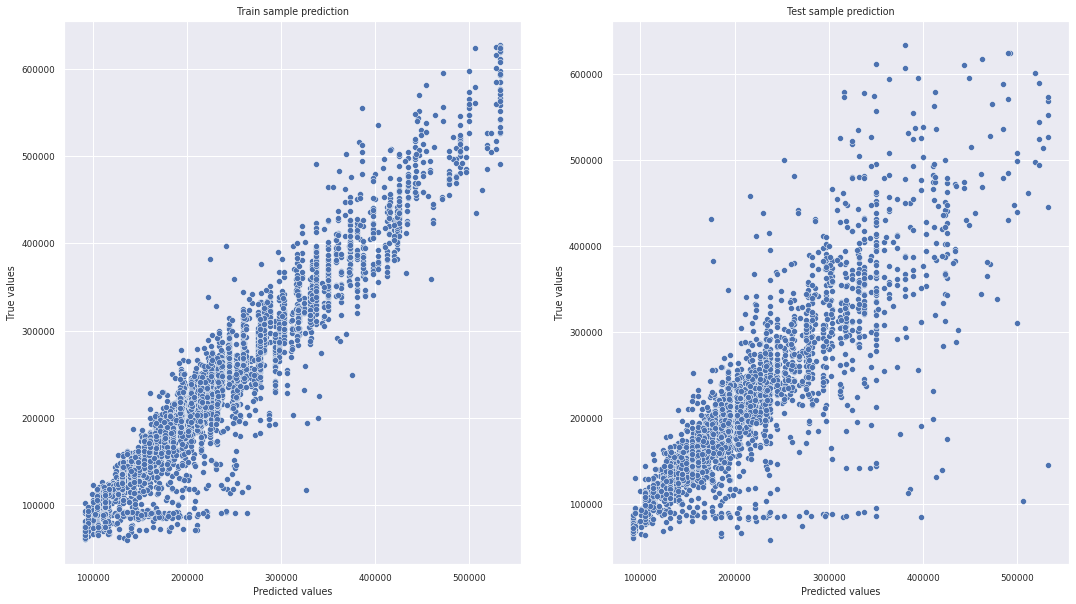

In [96]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [97]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.7833063 , 0.73832801, 0.76570942])

In [98]:
cv_score.mean()

0.7624479100050442

**Важность признаков**

In [99]:
feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

AttributeError: 'StackingRegressor' object has no attribute 'feature_importances_'

7.1 Оптимизация гипер-параметров

In [100]:
class HyperOptimizer:
    def optRandomForestRegressor():
        parameters = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': np.arange(5, 10),
        }

        return GridSearchCV(
            estimator=RandomForestRegressor(random_state=42),
            param_grid=parameters,
            scoring='r2',
            cv=5,
            n_jobs=-1)


8. Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Не потерять и не перемешать индексы от примеров при построении прогнозов
Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [101]:
test_df.shape

(5000, 24)

In [102]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,MedPriceByDistrict,MedPriceByFloorYear,FloorGood
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,0,76.0,0,171145.169069,188148.675311,2
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,164.0,0,131107.271962,182408.003180,2
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,0,0,0,1,580.0,0,165993.292450,181281.815896,1
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,0,372.0,0,172778.615365,178890.558191,1
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,1,65.0,0,164116.183543,188121.303704,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,1,1,...,1,0,1,0,0,56.0,0,183575.963167,188121.303704,0
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,26.0,0,425037.641820,204864.240211,2
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,0,0,0,0,54.0,0,156266.487610,178890.558191,2
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,1,0,0,0,0,40.0,0,185704.766694,188121.303704,2


In [103]:
submit = pd.read_csv(SAMPLE_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [104]:
predictions = model.predict(test_df)
predictions

array([160988.67795288, 140088.66823466, 143858.89252019, ...,
       148314.0101949 , 192506.47254988, 246452.6525073 ])

In [105]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160988.677953
1,5925,140088.668235
2,960,143858.892520
3,3848,132493.637438
4,746,177171.498921


In [106]:
submit.to_csv('rf_submit.csv', index=False)

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)
Необходимо получить R2 > 0.6 на Private Leaderboard.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 